In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/productivity-prediction-of-garment-employees/garments_worker_productivity.csv


In [6]:
#data wrangling
def wrangle(file):
    df=pd.read_csv(file)
    
    #dron null
    df=df.drop(columns="wip")
    #date to index as it is timeseries
    df["date"]=pd.to_datetime(df["date"])
    df=df.set_index("date")
    
    #remove outliers
    def remove_outliers(df):
        for col in df.select_dtypes(include=[int, float]).columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
            return df
    df = remove_outliers(df)
    #remove null column
    df= df.drop(columns=["idle_time","idle_men","no_of_style_change"])
    #remove correlated col
    df=df.drop(columns="smv")

    return df


In [8]:
for col in df.select_dtypes(include=[int, float]).columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [3]:
#import
df=wrangle("/kaggle/input/productivity-prediction-of-garment-employees/garments_worker_productivity.csv")


In [4]:
#checking
df.head()


,quarter,department,day,team,targeted_productivity,over_time,incentive,no_of_workers,actual_productivity
date,,,,,,,,,
2015-01-01,Quarter1,sweing,Thursday,8,0.80,7080,98,59.0,0.940725
2015-01-01,Quarter1,finishing,Thursday,1,0.75,960,0,8.0,0.886500
2015-01-01,Quarter1,sweing,Thursday,11,0.80,3660,50,30.5,0.800570
2015-01-01,Quarter1,sweing,Thursday,12,0.80,3660,50,30.5,0.800570
2015-01-01,Quarter1,sweing,Thursday,6,0.80,1920,50,56.0,0.800382


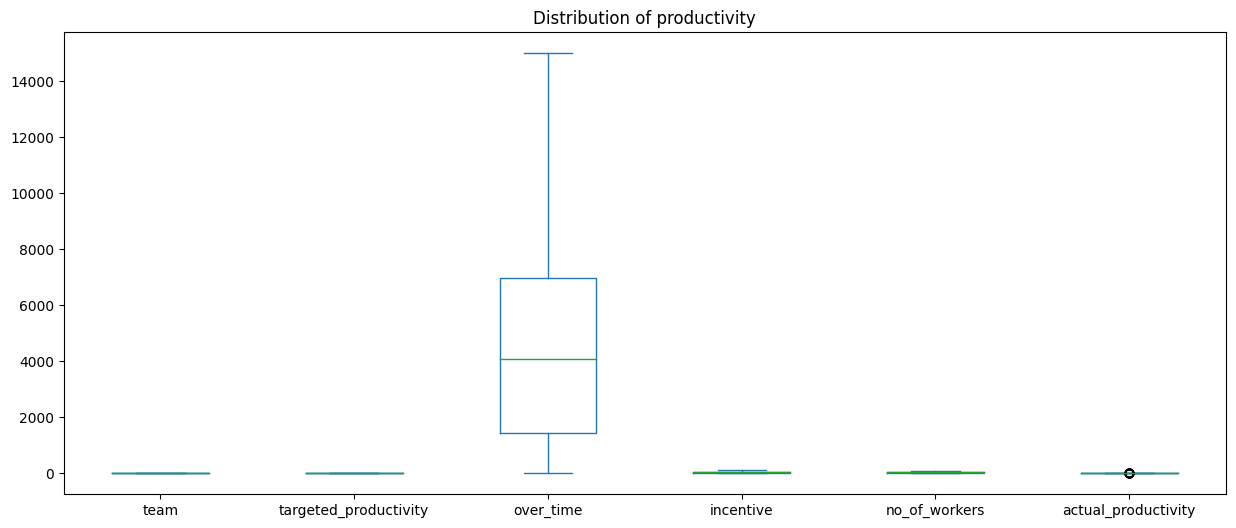

In [9]:
# new one
fig, ax = plt.subplots(figsize=(15, 6))
df.plot(kind="box",vert=True,title="Distribution of productivity",ax=ax);

In [11]:
df["actual_productivity"].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1047 entries, 2015-01-01 to 2015-03-11
Series name: actual_productivity
Non-Null Count  Dtype  
--------------  -----  
1047 non-null   float64
dtypes: float64(1)
memory usage: 16.4 KB


In [11]:
df["over_time"].values.max()

25920

In [41]:
df.select_dtypes("object").nunique()

quarter       5
department    3
day           6
dtype: int64

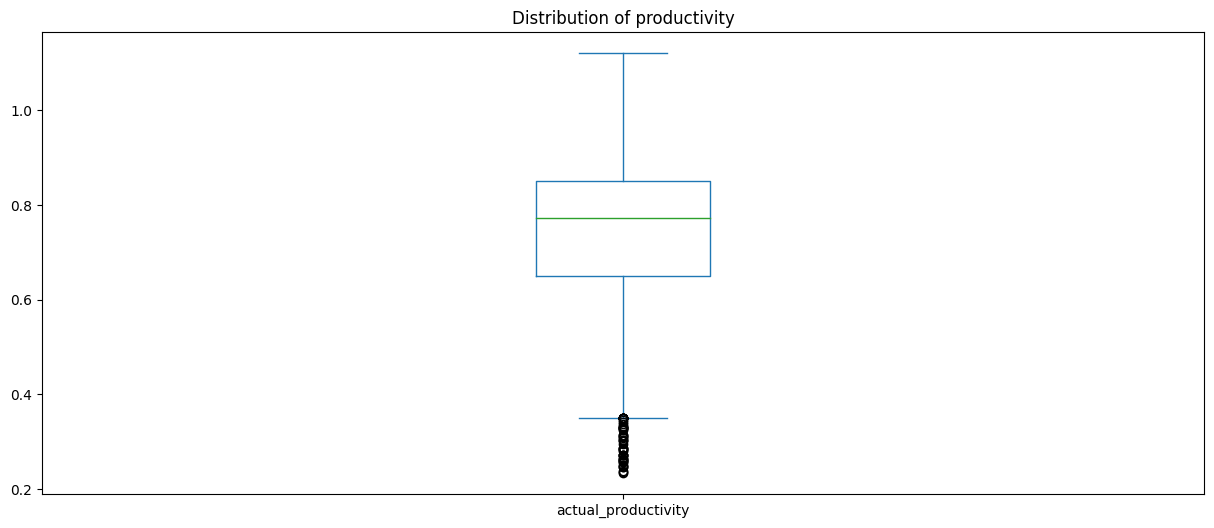

In [37]:
fig, ax = plt.subplots(figsize=(15, 6))
df["actual_productivity"].plot(kind="box",vert=True,title="Distribution of productivity",ax=ax);

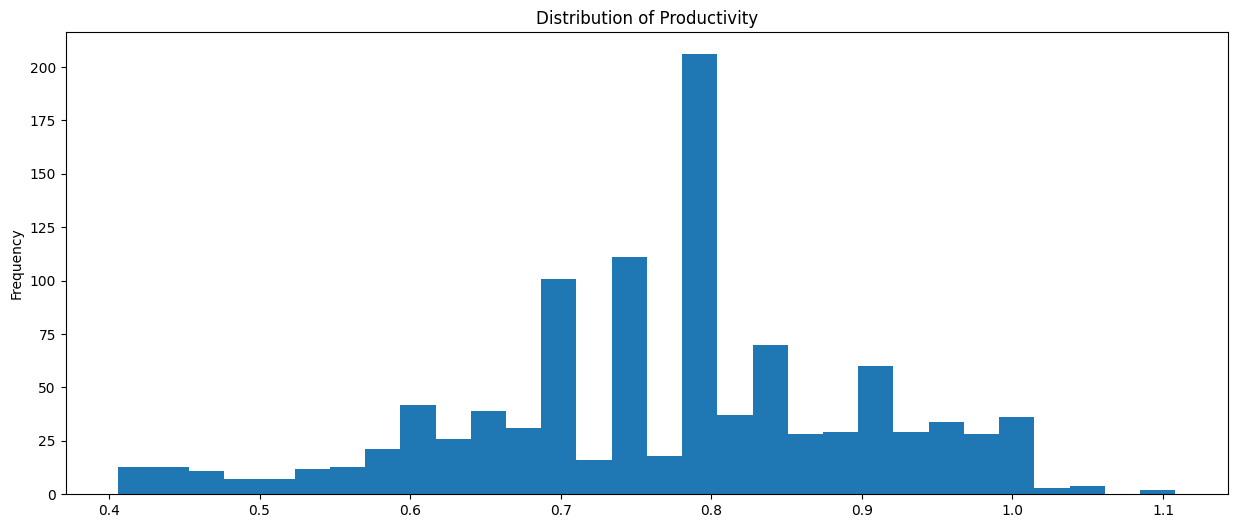

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
df["actual_productivity"].plot(kind="hist", bins=30, title="Distribution of Productivity", ax=ax)
plt.show()


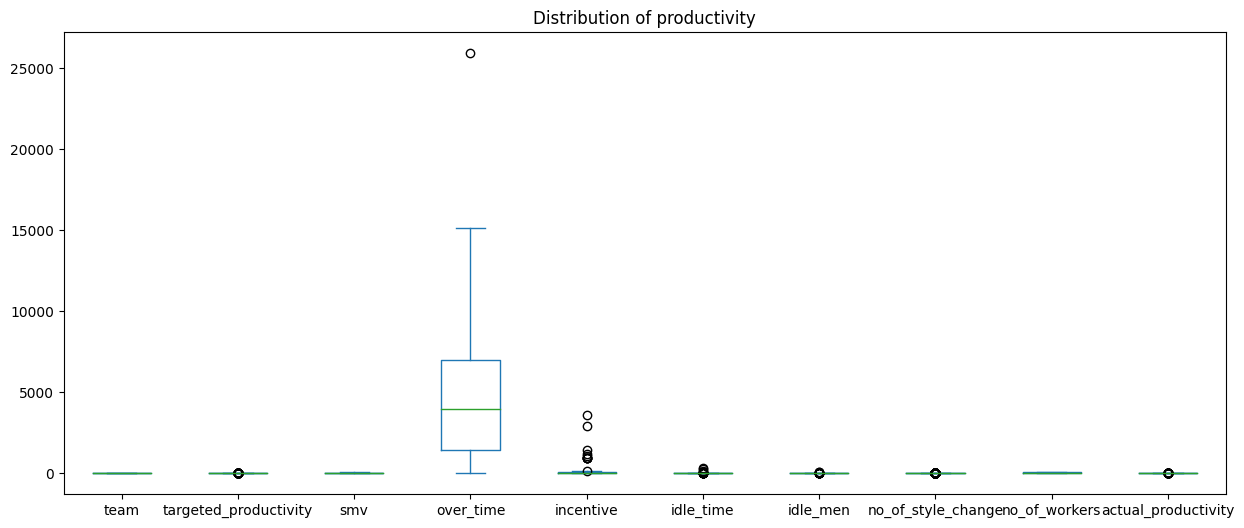

In [9]:
#before outliers
fig, ax = plt.subplots(figsize=(15, 6))
df.plot(kind="box",vert=True,title="Distribution of productivity",ax=ax);

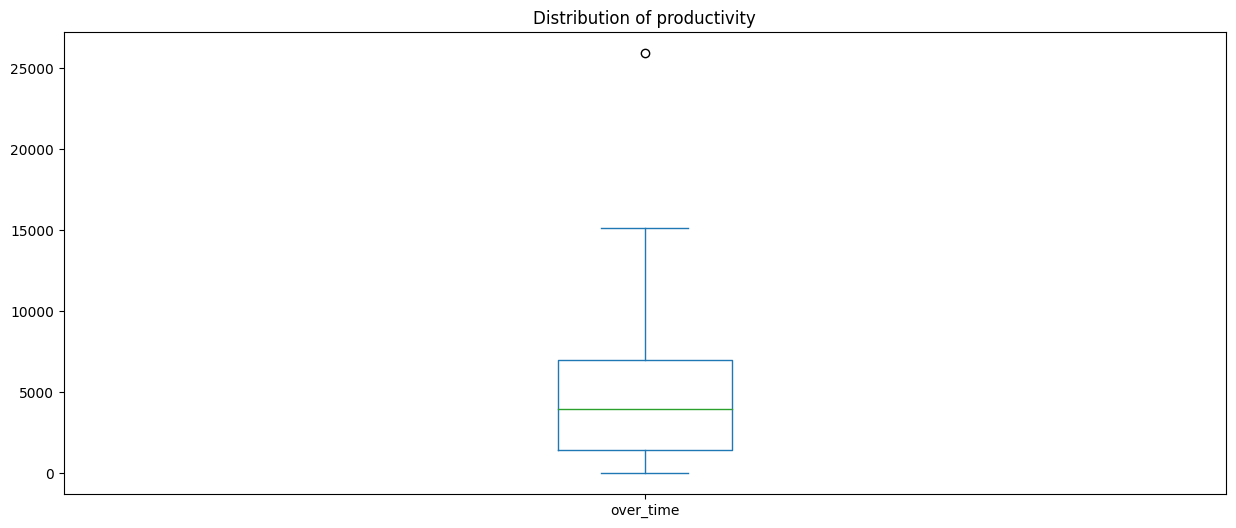

In [15]:

fig, ax = plt.subplots(figsize=(15, 6))
df["over_time"].plot(kind="box",vert=True,title="Distribution of productivity",ax=ax);

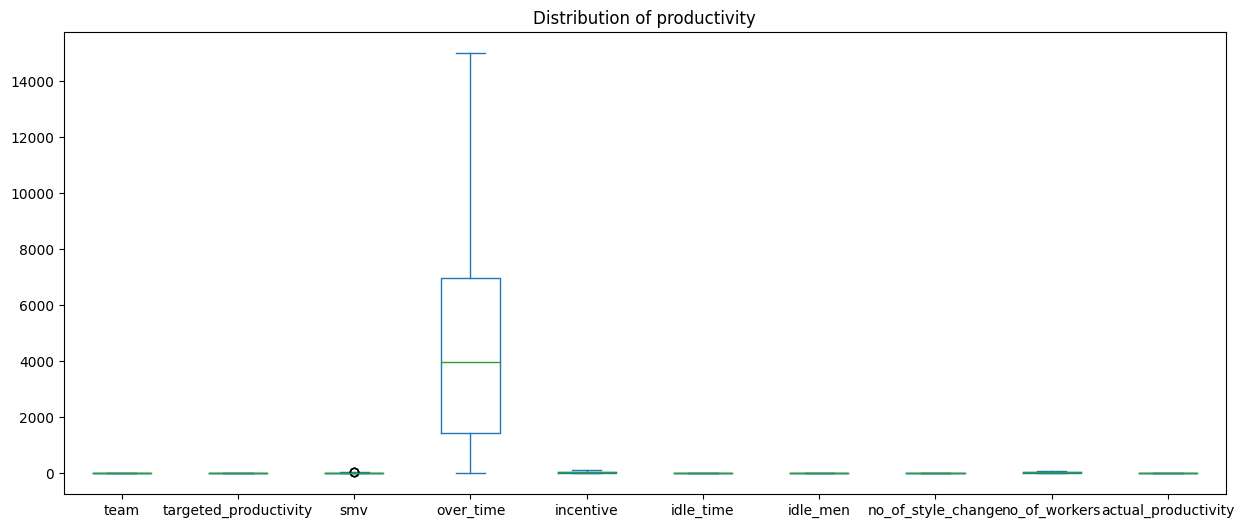

In [18]:
#after removing outliers
fig, ax = plt.subplots(figsize=(15, 6))
df.plot(kind="box",vert=True,title="Distribution of productivity",ax=ax);

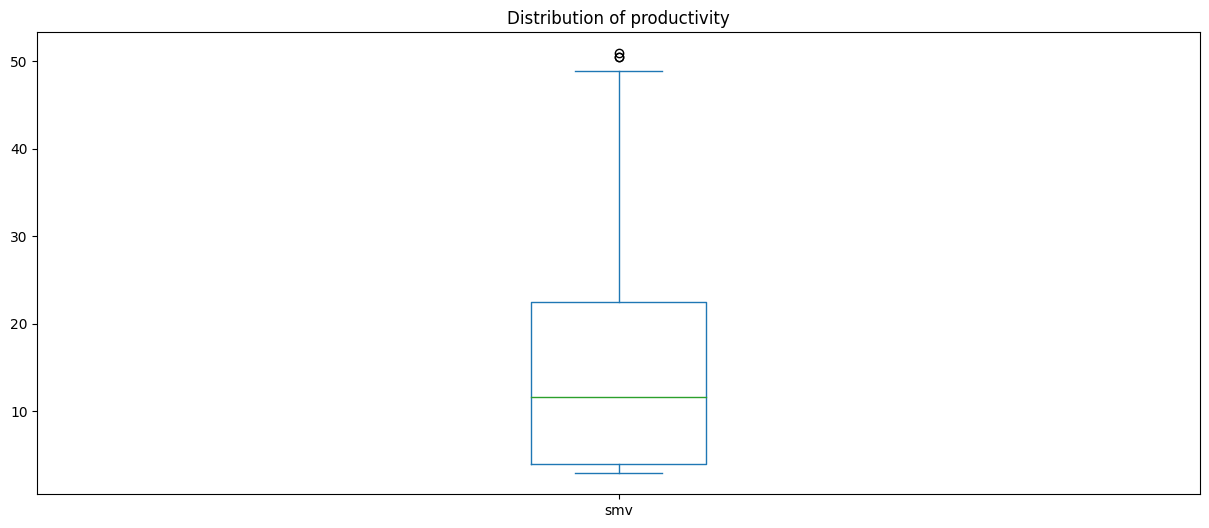

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
df["smv"].plot(kind="box",vert=True,title="Distribution of productivity",ax=ax);

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1047 entries, 2015-01-01 to 2015-03-11
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1047 non-null   object 
 1   department             1047 non-null   object 
 2   day                    1047 non-null   object 
 3   team                   1047 non-null   int64  
 4   targeted_productivity  1047 non-null   float64
 5   over_time              1047 non-null   int64  
 6   incentive              1047 non-null   int64  
 7   no_of_workers          1047 non-null   float64
 8   actual_productivity    1047 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 81.8+ KB


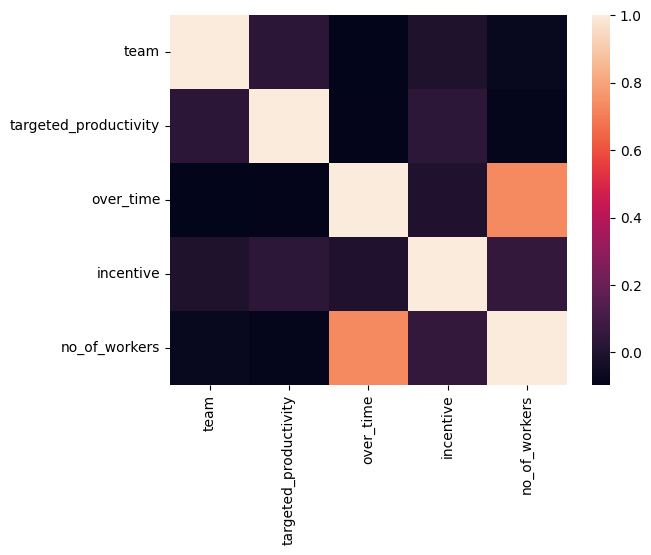

In [53]:
#after removing correlated matrix
corr= df.select_dtypes("number").drop(columns="actual_productivity").corr()
sns.heatmap(corr);

In [54]:
corr

,team,targeted_productivity,over_time,incentive,no_of_workers
team,1.000000,0.030274,-0.096737,-0.007674,-0.075113
targeted_productivity,0.030274,1.000000,-0.088557,0.032768,-0.084288
over_time,-0.096737,-0.088557,1.000000,-0.004793,0.734164
incentive,-0.007674,0.032768,-0.004793,1.000000,0.049222
no_of_workers,-0.075113,-0.084288,0.734164,0.049222,1.000000


In [10]:
features=df.drop(columns=["actual_productivity"])
target="actual_productivity"
X=features
y=df[target]

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1047 entries, 2015-01-01 to 2015-03-11
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1047 non-null   object 
 1   department             1047 non-null   object 
 2   day                    1047 non-null   object 
 3   team                   1047 non-null   int64  
 4   targeted_productivity  1047 non-null   float64
 5   over_time              1047 non-null   int64  
 6   incentive              1047 non-null   int64  
 7   no_of_workers          1047 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 73.6+ KB


In [12]:
y.head()

date
2015-01-01    0.940725
2015-01-01    0.886500
2015-01-01    0.800570
2015-01-01    0.800570
2015-01-01    0.800382
Name: actual_productivity, dtype: float64

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['quarter','department','day']),  # Apply one-hot encoding to 'category' column
        ('num', StandardScaler(), ['team', 'over_time', 'incentive'])  # Scale numeric columns
      
    ],
   remainder='passthrough'
)

In [64]:
#not required #preprocessor.fit_transform(X)
#preprocessor.get_feature_names_out()

array(['cat__quarter_Quarter1', 'cat__quarter_Quarter2',
       'cat__quarter_Quarter3', 'cat__quarter_Quarter4',
       'cat__quarter_Quarter5', 'cat__department_finishing',
       'cat__department_finishing ', 'cat__department_sweing',
       'cat__day_Monday', 'cat__day_Saturday', 'cat__day_Sunday',
       'cat__day_Thursday', 'cat__day_Tuesday', 'cat__day_Wednesday',
       'num__team', 'num__over_time', 'num__incentive'], dtype=object)

In [21]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
len(X_train)

837

In [24]:
model=make_pipeline(
    preprocessor,
    LinearRegression()
)

In [20]:
len(X_train)

837

In [39]:
len(X_test)

210

In [45]:
len(y_train)

837

In [25]:
model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['quarter', 'department',
                                                   'day']),
                                                 ('num', StandardScaler(),
                                                  ['team', 'over_time',
                                                   'incentive'])])),
                ('linearregression', LinearRegression())])

In [28]:
#train value
y_pred=model.predict(X_train)
train_mae=mean_absolute_error(y_train,y_pred)
print("Training MAE:",train_mae)

Training MAE: 0.07389052801706383


In [31]:
#test value 
y_pred_test=model.predict(X_test)
test_mae=mean_absolute_error(y_test,y_pred_test)
print("Testing MAE:",test_mae)

Testing MAE: 0.06964147112064267


In [36]:
#visualizing results
df_test=pd.DataFrame({
    "y_test": y_test,
    "y_pred_test": y_pred_test
})

In [37]:
df_test.head()

,y_test,y_pred_test
date,,
2015-01-22,0.600436,0.537589
2015-02-05,0.999924,0.796000
2015-03-01,0.700237,0.677109
2015-03-08,0.850071,0.830866
2015-01-03,0.800125,0.764580
